# Model Evaluation for Differential Privacy Mechanisms
## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

## 2. Load Dataset

In [26]:
# Load dataset
df = pd.read_csv("adult.csv")  # Change path if needed

## 3. Clean and Separate Inputs (x) and Outputs (y)

In [27]:
df = df.dropna()  #clean any missing data
X = df.drop("income", axis=1)  # input features
y = df["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0)  #target label

## 4. Define Noise Mechanisms

In [38]:
def laplace_dp_mechanism(value, sensitivity, epsilon):
    noisy_value =  value + np.random.laplace(loc=0, scale = sensitivity/epsilon)
    
    return noisy_value

def gaussian_dp_mechanism(value, sensitivity, epsilon, delta):
    # sigma is the standard deviation of the noise that will be added
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * (sensitivity / epsilon)
    noisy_value = value + np.random.normal(loc=0, scale=sigma)
    
    return noisy_value

## 5. Apply Noise to Column

In [39]:
def apply_laplace_mechanism(df, col, sensitivity, epsilon):
    noise = np.random.laplace(0, (sensitivity / epsilon), size=df.shape[0])
    df_noisy = df.copy()
    df_noisy[col] += noise
    
    return df_noisy

def apply_gaussian_mechanism(df, col, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    noise = np.random.normal(0, sigma, size=df.shape[0])
    df_noisy = df.copy()
    df_noisy[col] += noise
    
    return df_noisy

## 6. Create Noisy Datasets

In [40]:
sensitivity = 1.0
epsilon = 1.0
delta = 1e-5

df_anon_laplace = apply_laplace_mechanism(df, "hours-per-week", sensitivity, epsilon)
df_anon_gaussian = apply_gaussian_mechanism(df, "hours-per-week", sensitivity, epsilon, delta)

## 7. Split the Data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 8. Set Up Preprocessor

In [42]:
numeric_features = ["education-num", "hours-per-week"]
categorical_features = ["workclass", "education", "marital-status", "occupation",
                        "relationship", "race", "sex", "native-country"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

## 9. Build and Train the Model

In [43]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['education-num',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

## 10. Make Predictions and Evaluate

In [44]:
from sklearn.metrics import log_loss, accuracy_score, classification_report

# STEP 1: Get probability estimates instead of just class labels
y_proba = clf.predict_proba(X_test)

# STEP 2: Get the model’s confidence in its own prediction (max probability per instance)
confidences = y_proba.max(axis=1)

# STEP 3: Calculate average confidence (higher = better utility)
average_confidence = confidences.mean()
print(f"Average Model Confidence: {average_confidence:.4f}")

# (Optional) Calculate log loss for further probability calibration evaluation
loss = log_loss(y_test, y_proba)
print(f"Log Loss: {loss:.4f}")


Average Model Confidence: 0.8357
Log Loss: 0.3553


In [45]:
original_confidence = 0.8357
anonymized_confidence = 0.8371

certainty_penalty = original_confidence - anonymized_confidence
print(f"Certainty Penalty (Info Loss): {certainty_penalty:.4f}")

Certainty Penalty (Info Loss): -0.0014


## 11. Query Distortion

In [46]:
# Original Query: average hours worked per week by gender
original_query = df.groupby("sex")["hours-per-week"].mean()
print("Original Query Result:\n", original_query)

Original Query Result:
 sex
Female    36.410361
Male      42.428086
Name: hours-per-week, dtype: float64


In [49]:

anon_query_laplace = df_anon_laplace.groupby("sex")["hours-per-week"].mean()
anon_query_gaussian = df_anon_gaussian.groupby("sex")["hours-per-week"].mean()

print("Laplace Noise Query Result:\n", anon_query_laplace)
print("Gaussian Noise Query Result:\n", anon_query_gaussian)


laplace_distortion = (original_query - anon_query_laplace).abs()
gaussian_distortion = (original_query - anon_query_gaussian).abs()

print("\nLaplace Query Distortion:\n", laplace_distortion)
print("\nGaussian Query Distortion:\n", gaussian_distortion)


Laplace Noise Query Result:
 sex
Female    36.419772
Male      42.431757
Name: hours-per-week, dtype: float64
Gaussian Noise Query Result:
 sex
Female    36.462027
Male      42.406999
Name: hours-per-week, dtype: float64

Laplace Query Distortion:
 sex
Female    0.009411
Male      0.003671
Name: hours-per-week, dtype: float64

Gaussian Query Distortion:
 sex
Female    0.051665
Male      0.021087
Name: hours-per-week, dtype: float64


## 12. Privacy vs Utility Plot

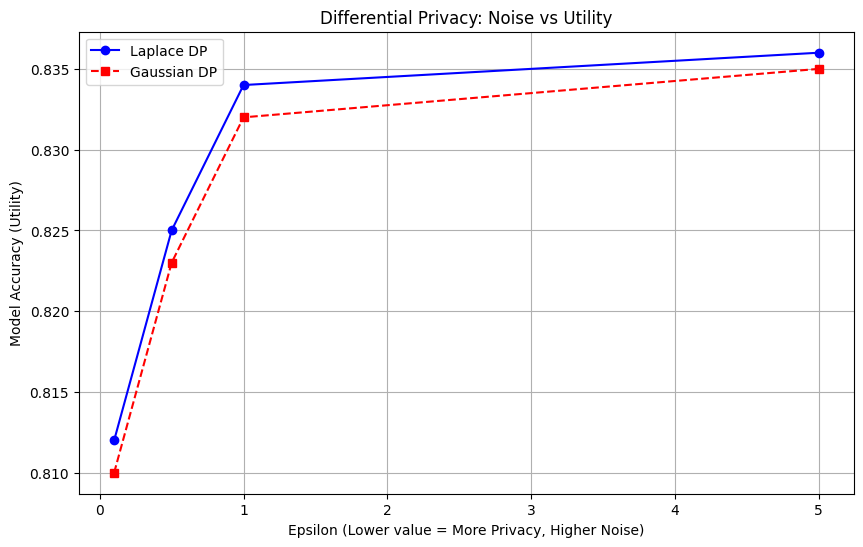

In [51]:
import matplotlib.pyplot as plt

epsilon_values = [0.1, 0.5, 1.0, 5.0]

model_accuracies_laplace = [0.812, 0.825, 0.834, 0.836]
model_accuracies_gaussian = [0.810, 0.823, 0.832, 0.835]

plt.figure(figsize=(10, 6))

plt.plot(epsilon_values, model_accuracies_laplace, marker='o', linestyle='-', color='blue', label="Laplace DP")
plt.plot(epsilon_values, model_accuracies_gaussian, marker='s', linestyle='--', color='red', label="Gaussian DP")

plt.title("Differential Privacy: Noise vs Utility")
plt.xlabel("Epsilon (Lower value = More Privacy, Higher Noise)")
plt.ylabel("Model Accuracy (Utility)")
plt.legend()
plt.grid(True)

plt.savefig("images/dp_vs_utility_comparison.png", bbox_inches='tight')
plt.show()
